<a href="https://colab.research.google.com/github/Yalnyra/Intel-Image-Dataset/blob/main/Vinokur_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- У класі "street" і "glacier" багато чорно-білих фото, спробуємо grayscale зображень. Зображення вдень і вночі, в різні часи доби і освітлення. Різна розмірність фічей, як от куполів на фото, тому спробувати Resize.

Зображення чіткі, шумів не знайдено,

Припускаємо із візуалізованих даних, що всі належать до одного з 5 класів і відсутні wildcard класи.


TODO: Спробуємо знайти "щільність" кластерів даних об'єктів за допомогою UMAP, t-SNE чи PCA, іншої кластеризації для візуалізації відстаней, і позначити кольором до яких класів кожен датапоінт належить.

Dot-product зображень, t-test на корреляцію.
Корреляцію між зображеннями, scatter plot по PCA

Для обробки поки не виконуємо нормалізацію, треба невелику
- аугментація 20% зображень із одним з трьох варіантів
 - випадковим розширенням і поворотом для scale/affine invariance
 - Перетворенням на чорно-біле зображення
 0. Для великого зображення 150*150*3 збільшимо к-сть згорток з 4 до 6, з розмірами фіч мап
 0. Макс 4*4 пулінг
 1. Батч нормалізація

Що буде зроблено на даному етапі
<!-- - Зробимо взважування по частоті -->
-
<!-- - Спробуємо спочатку постійний learning rate, потім ще додамо з Lr scheduler. -->
- У Adam додамо параметр регуляризації


# Фінальний проєкт
## Класифікація зображень за допомогою PyTorch

**Мета роботи: Навчитись тренувати базову нейронну мережу для класифікації зображень.**

**Вимоги:**
1. Препроцессинг, train/pred, тест повністю на розмічених зображеннях.


 Аугментація: blur/grayscale/affine transform/noise

2. Архітектура:

 - Пару CNN шарів, 2-3 Linear

 - Max/median pooling, batch norm

3. Lr_rate finetuning,


In [ ]:
# @title Для colab потрібно опціональні частини torch
# %pip install torchvision

In [ ]:
# Image load

import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
# import torchvision
from torchvision.transforms import v2 as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid
from torch.optim import Adam, lr_scheduler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, ConfusionMatrixDisplay
# import wandb


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Не працюємо з kaggle - встановіть [Dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification/code) на гугл диск у папку URL перед початком роботи.

Логінитись у wandb не треба, просто закоментуйте
наступнф два рядки

In [ ]:
import wandb

In [ ]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gpjedi (paradoxv15) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
URL = "drive/MyDrive/Intel-Image-Classification"
# Альтернативний шлях, якщо працюєте з kaggle
# URL = "/kaggle/input/intel-image-classification"
folder = {"kaggle": 'seg_pred/seg_pred',
          'train': 'seg_train/seg_train',
          'test': 'seg_test/seg_test'
          }
BATCH_SIZE = 64
_NUM_WORKERS = os.cpu_count() // 2
_INPUT_SIZE = 150
SEED = 1234

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(X, y):
    return X.to(device), y.to(device, dtype=torch.int64)

In [ ]:
rng = np.random.default_rng(seed=SEED)

In [ ]:
# @title loading image from Intel Image folder
# @markdown # Запишемо всі лейбли і шляхи до файлів, -1 відповідає за непомічені дані
class ImageDataset(Dataset):
    def __init__(self, root_dir, train=True, transform=None, generator=rng):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.img_label_pairs = []
        self.classes = []
        self.subdir = 'seg_train/seg_train' if train else 'seg_test/seg_test'

        # Collect all image paths and their corresponding labels
        subdir_path = os.path.join(root_dir, self.subdir)
        for class_name in os.listdir(subdir_path):
            class_path = os.path.join(subdir_path, class_name)
            if os.path.isdir(class_path):
                if class_name not in self.classes:
                    # self.classes[class_name] = len(self.classes)
                    self.classes.append(class_name)
                for filename in os.listdir(class_path):
                    if filename.endswith('.jpg'):
                        self.img_label_pairs.append(
                            (os.path.join(class_path, filename),self.classes.index(class_name)))

        # # Collect images from seg_pred (unlabeled data)
        # unlabeled = os.path.join(root_dir, 'seg_pred/seg_pred')
        # for filename in os.listdir(unlabeled):
        #     if filename.endswith('.jpg'):
        #         self.img_label_pairs.append(
        #         (os.path.join(unlabeled, filename),-1)
        #         )

        rng.shuffle(self.img_label_pairs)



    @staticmethod
    def _to_tensor(image):
        return transforms.Compose([
            # transforms.ToImage(),
            # transforms.ToDtype(torch.float32, scale=True)
            transforms.ToTensor()
            ])(image)

    def __len__(self):
        return len(self.img_label_pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path, label = self.img_label_pairs[idx]
        # image = ImageDataset._to_tensor(Image.open(img_path).convert('RGB'))
        image = Image.open(img_path)
        label = torch.tensor(label, dtype=torch.int)

        if self.transform:
            image = self.transform(image)

        return image, label

# Example usage:
# Define any transformations you want to apply to the images
transform = transforms.Compose([
    # transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Create the dataset
dataset = ImageDataset(root_dir=URL, transform=transform)

# Access an image tensor and its label
image_tensor, label = dataset[0]
print(image_tensor.shape, label)
classes = dataset.classes


/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


torch.Size([3, 150, 150]) tensor(3, dtype=torch.int32)


Імплементація зверху дуже повільна

In [ ]:
URL

'drive/MyDrive/Intel-Image-Classification'

[Пост з stackoverlow](https://discuss.pytorch.org/t/accelerate-imagefolder-based-dataset-loading/195120/2) для пришвидшення завантаження



In [ ]:
import h5py

In [ ]:
INPUT_SIZE = 150

In [ ]:
def create_hdf5_dataset(root_folder: str,
                        hdf5_file: str,
                        target_size: tuple[int, int] = (INPUT_SIZE, INPUT_SIZE),
                        channels: int = 3) -> None:
    """ Create an hdf5 database file from a folder containing images.
    The images are resized to the target_size and stored in the hdf5 file.
    This is useful when your dataset cannot fit in RAM and the data consits of many images"""
    transform = transforms.Compose([
        transforms.Resize((150,150), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
        transforms.CenterCrop((150,150)),
        transforms.ToTensor(),
    ])

    # check if data_dir points towards an existing directory
    if not os.path.isdir(root_folder):
        error_string = f"Directory '{root_folder}' not found."
        raise FileNotFoundError(error_string)

    # generate dataset
    try:
        data = datasets.ImageFolder(root=root_folder, transform=transform)
        # set chunk size for loading data and appending to hdf5 file
        chunk_size = min(int(len(data) / 10), 1000)
    except Exception as e:
        raise e

    num_images = len(data)

    # open the hdf5 file
    with h5py.File(hdf5_file, "w") as file:
        # Create datasets with chunks for efficient storage
        img_dataset = file.create_dataset("images", shape=(num_images,
                                                           channels,
                                                           target_size[0],
                                                           target_size[1]),
                                          dtype="float32", chunks=None)
        lbl_dataset = file.create_dataset("labels", shape=(num_images,),
                                          dtype="int64", chunks=None)
        print(img_dataset.shape)
        loader = DataLoader(data, batch_size=chunk_size, shuffle=False, num_workers=_NUM_WORKERS)

        current_index = 0
        # start batch processing (to avoid RAM overflow)
        for images, labels in tqdm(loader):
            chunk_size = images.size(0)

            images = np.array(images)
            labels = np.array(labels)

            img = torch.tensor(images, dtype=torch.float32)
            # img = torch.permute(img, (0, 2, 1, 3))
            lbl = torch.tensor(labels, dtype=torch.long)

            img_dataset[current_index:current_index + chunk_size] = img
            lbl_dataset[current_index:current_index + chunk_size] = lbl
            print(img_dataset.shape)
            current_index += chunk_size

In [ ]:
""" Custom dataset for loading images from an hdf5 file.
    This system lazy loads the images from the hdf5 file."""

class Hdf5Dataset(Dataset):
    def __init__(self, hdf5_file: str, transform: transforms = None) -> None:
        self.hdf5_file = hdf5_file
        self.transform = transform
        self.dataset = None

        with h5py.File(hdf5_file, "r") as file:
            self.length = len(file["images"])

    def __len__(self) -> int:
        return self.length

    def classes(self):
      return np.unique()

    def __getitem__(self, idx) -> tuple[torch.Tensor, int]:
        """ Returns a tuple of image and label."""
        if self.dataset is None:
            self.dataset = h5py.File(self.hdf5_file, mode="r", swmr=True)

        image = self.dataset["images"][idx]
        label = self.dataset["labels"][idx]
        image = np.permute_dims(image, (2,1,0))
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
"""
Args:
    root_dir (string): Directory with all the images.
    transform (callable, optional): Optional transform to be applied on a sample.
"""

train_dir = os.path.join(URL, folder['train'])
test_dir  = os.path.join(URL, folder['test'])
train_hdf5 = os.path.join(train_dir,'train.hdf5')
test_hdf5 = os.path.join(test_dir,'test.hdf5')

Експортуємо дані у ту саму папку один раз, але у єдиному файлі .hdf5

In [ ]:
if not os.path.isfile(train_hdf5):
  create_hdf5_dataset(train_dir, train_hdf5)
if not os.path.isfile(test_hdf5):
  create_hdf5_dataset(test_dir, test_hdf5)


In [ ]:
# Create the dataset
dataset = Hdf5Dataset(train_hdf5, transform=transform)

# Access an image tensor and its label
image_tensor, label = dataset[0]
print(image_tensor.shape, label)

torch.Size([3, 150, 150]) 0


In [ ]:
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
class WrappedDataLoader:
    def __init__(self, loader, func):
        self.loader = loader
        self.func = func

    def __len__(self):
        return len(self.loader)

    def __iter__(self):
        for batch in iter(self.loader):
            yield self.func(*batch)

In [ ]:
affine_transforms = transforms.Compose([
    transforms.RandomAffine(degrees=15, translate=(0.05, 0.15), scale=(0.85, 1.15), interpolation=transforms.InterpolationMode.BILINEAR),
    # transforms.RandomResizedCrop(size=(150, 150), scale=(0.15, 1), ratio=(1,1), antialias=True),
    # transforms.RandomHorizontalFlip(p=0.),
])

augmentations = transforms.Compose([
    transforms.GaussianNoise(sigma=0.1),
    # transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
])

In [ ]:
color_transforms = transforms.Compose([
    # transforms.Normalize(features_mean, features_std),
    transforms.ColorJitter(brightness=0.5, contrast=0.1, saturation=0.01),
])

In [ ]:
repeats = 50
features_size = BATCH_SIZE * repeats

In [ ]:
# features_mean = torch.zeros(1)
# features_squared_mean = torch.zeros(1)
# # Only use a few batches
# for item, label in data_train:
#     item = test_transforms(item)
#     features_mean += torch.mean(item)
#     features_squared_mean += torch.mean(item ** 2)
#     print(repeats)
#     repeats -= 1
#     if repeats <= 0:
#       break

# features_mean /= features_size
# features_squared_mean /= features_size

# features_std = torch.sqrt(features_squared_mean - features_mean ** 2)

In [ ]:
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((150,150), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
    transforms.CenterCrop((150,150)),
    ])

In [ ]:
train_transforms = transforms.Compose([
    # transforms.ToDtype(torch.float32, scale=True),
    transforms.ToTensor(),
    # transforms.Resize((150,150), interpolation=transforms.InterpolationMode.BILINEAR, max_size=None, antialias=True),
    # transforms.CenterCrop((150,150)),
  #   transforms.RandomApply([
  #   transforms.RandomChoice([
    affine_transforms,
    # augmentations,
  #       # color_transforms,
  #   ],)
  # ], p=0.2),
  transforms.RandomGrayscale(p=0.2),
])


In [ ]:
def loss(model, loss_func, X, y, optimizer=None):
    loss_ = loss_func(model(X), y)
    if optimizer is not None:
      loss_.backward()
      optimizer.step()
      optimizer.zero_grad()

    return loss_.item(), len(X)

In [ ]:
def validate(model, loss_func, X, y):
    output = model(X)
    loss_ = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return loss_.item(), torch.sum(correct).item(), len(X), pred, y.view(*pred.shape)

In [ ]:
def fit(epochs, model, loss_func, optimizer, train_loader, valid_loader, lr_scheduler=None, patience=10):
    graphic_losses = []

    wait = 0
    valid_loss_min = np.inf
    step = 0

    for epoch in tqdm(range(epochs)):
        step = epoch
        model.train()

        losses = []
        for X, y  in train_loader:
          # print(X.shape)
          losses.append(loss(model, loss_func, X, y, optimizer))

        losses, nums = zip(*losses)
        train_loss = sum(np.multiply(losses, nums)) / sum(nums)

        model.eval()

        with torch.no_grad():

            losses = []
            for X, y in valid_loader:
              losses.append(validate(model, loss_func, X, y))


            losses, corrects, nums, predicted, target = zip(*losses)
            target = torch.cat([*target], dim=0).cpu()
            predicted = torch.cat([*predicted],dim=0).cpu()
            valid_loss = sum(np.multiply(losses, nums)) / sum(nums)
            valid_accuracy = sum(corrects) / sum(nums) * 100
            # Changed from total class per-point  to average weighted
            valid_precision = precision_score(target, predicted, average='weighted')
            valid_recall = recall_score(target, predicted,  average='weighted')
            valid_f1 = f1_score(target, predicted,  average='weighted')

            # reduce lr based on val loss
            if lr_scheduler is not None:
              lr_scheduler.step(valid_loss)

            print(f"\nepoch: {epoch+1:3}, loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, valid accuracy: {valid_accuracy:.3f}, valid f1: {valid_f1:.3f}%")

            graphic_losses.append((train_loss, valid_loss, valid_accuracy, valid_precision, valid_recall, valid_f1))
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return graphic_losses, step

    return graphic_losses, step

### Тестування моделі

- На додачу до простого Accuracy, потрібно знайти
Precision
$TP \div (TP+FP)$

Recall
$TN \div (TN+FN)$

F1 $\frac{1}{\frac{1}{Precision}+\frac{1}{Recall}} $

Матрицю зкуйовдженості

In [ ]:
def evaluate(model, loss_func, loader):
    model.eval()

    with torch.no_grad():
        validated_batches = []

        for X, y in loader:
          validated_batches.append(validate(model, loss_func, X, y))

        losses, corrects, nums, predicted, target = zip(*validated_batches)
        target = torch.cat([*target], dim=0).cpu()
        predicted = torch.cat([*predicted],dim=0).cpu()
        cm = ConfusionMatrixDisplay.from_predictions(target, predicted)
        plt.show()
        test_loss = sum(np.multiply(losses, nums)) / sum(nums)
        test_accuracy = sum(corrects) / sum(nums) * 100
        test_precision = precision_score(target, predicted,  average='micro')
        test_recall = recall_score(target, predicted,  average='micro')
        test_f1 = f1_score(target, predicted,  average='micro')



    print(f"Test loss: {test_loss:.5f}\t",
          f"Test accuracy: {test_accuracy:.3f}%",
          f"Test precision: {test_precision:.3f}",
          f"Test recall: {test_recall:.3f}"
          f"Test f1: {test_f1:.3f}")
    return test_loss, test_accuracy, test_precision, test_recall, test_f1, cm

In [ ]:
def training_plots(losses_arr):
    plt.figure(figsize=(8,6))
    plt.plot([x[2] for x in losses_arr])
    plt.ylabel('Accuracy in %')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[3] for x in losses_arr])
    plt.ylabel('Precision')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[4] for x in losses_arr])
    plt.ylabel('Recall')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[5] for x in losses_arr])
    plt.ylabel('F1')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

    plt.figure(figsize=(8,6))
    plt.plot([x[0] for x in losses_arr], label='train loss')
    plt.plot([x[1] for x in losses_arr], label='validation loss')
    plt.legend(loc="upper right")
    plt.ylabel('Losses')
    plt.xlabel('Epochs')
    plt.xticks([x + 1 for x in range(len(losses_arr)) if x % 2 == 1])
    plt.show()

In [ ]:
model_path = lambda name: f"{URL}/{name}.pt"

In [ ]:
if not os.path.exists(model_path('')):
      os.makedirs(model_path(''))

In [ ]:
train_transforms

# valid_transforms

# test_transforms

Compose(
      ToTensor()
      Compose(    RandomAffine(degrees=[-15.0, 15.0], translate=(0.05, 0.15), scale=(0.85, 1.15), interpolation=InterpolationMode.BILINEAR, fill=0))
      RandomGrayscale(p=0.2)
)

In [ ]:
def train(model, criterion, optimizer, n_epochs, batch_size, train_transforms, lr_scheduler=None, saving_model_path=None, wb = False):

    # data_train = ImageDataset(URL, True, train_transforms

    # data_test = ImageDataset(URL, test_transforms)

    # data_train = datasets.ImageFolder(train_dir, train_transforms)
    # data_test = datasets.ImageFolder(test_dir, test_transforms)

    data_train = Hdf5Dataset(train_hdf5, transform=train_transforms)

    data_test = Hdf5Dataset(test_hdf5, transform=test_transforms)

    print(data_train.transform)
    data_train, data_valid = random_split(data_train, lengths=[0.8, 0.2])


    loader_train = WrappedDataLoader(DataLoader(data_train, batch_size=batch_size, shuffle=True), to_device)
    loader_eval = WrappedDataLoader(DataLoader(data_valid, batch_size=batch_size, shuffle=False), to_device)
    loader_test = WrappedDataLoader(DataLoader(data_test, batch_size=batch_size, shuffle=False), to_device)

    print('\nFitting nn model')
    start_time = time.time()

    train_losses, final_step = fit(n_epochs, model, criterion, optimizer, loader_train, loader_eval, lr_scheduler)
    print(f'length array:', len(train_losses))
    print(f'Fit time: {time.time() - start_time} s')
    if wb:
        wandb.log({"train/duration": time.time() - start_time})
    check_point = torch.load('model.pt', map_location=device)
    model.load_state_dict(check_point)

    eval_losses = evaluate(model, criterion, loader_test)

    if saving_model_path is not None:
        print('Saving model')
        # create 'dynamic' dir, if it does not exist
        if not os.path.exists(model_path('')):
          os.makedirs(model_path(''))
        torch.save(model.state_dict(), model_path(saving_model_path))
        if wb:
            wandb.log_model(path=model_path(saving_model_path),name=saving_model_path)
            for i in range(final_step):
                train_loss, v_loss, v_acc, v_prec, v_recall, v_f1 = train_losses[i]
                wb_dict = {
                    "train/loss": train_loss,
                    "valid/loss": v_loss,
                    "valid/accuracy": v_acc,
                    "valid/precision": v_prec,
                    "valid/recall": v_recall,
                    "valid/f1": v_f1,
                           }
                wandb.log(wb_dict, step=i)
            test_loss, t_acc, t_prec, t_recall, t_f1, fig = eval_losses
            wandb.log({"test/loss": test_loss,
                    "test/accuracy": t_acc,
                    "test/precision": t_prec,
                    "test/recall": t_recall,
                    "test/f1": t_f1}, step=final_step+1)
            wandb.log({"fig":wandb.Image(fig.confusion_matrix)})

    training_plots(train_losses)

In [ ]:
class BasicModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 32 * 3 -> 16 -> 16
        self.bn11 = nn.BatchNorm2d(3)
        self.conv11 = nn.Conv2d(3, 75, 3, padding="same") #3/16
        self.bn12 = nn.BatchNorm2d(75) # 16
        self.conv12 = nn.Conv2d(75, 75, 3, padding="same") #16/16
        self.bn21 = nn.BatchNorm2d(75) # 16
        self.conv21 = nn.Conv2d(75, 450, 3, padding="same") #16/32
        self.bn22 = nn.BatchNorm2d(450) # 32
        self.conv22 = nn.Conv2d(450, 450, 3, padding="same") #32/32 -> 150 * 37 * 37
        self.bn31 = nn.BatchNorm2d(450) # 16
        self.conv31 = nn.Conv2d(450, 1350, 3, padding="same") #16/32 -> 450*9*9
        self.bn32 = nn.BatchNorm2d(1350) # 32
        self.conv32 = nn.Conv2d(1350, 1350, 3, padding="same") #32/32 -> 1350*2*2

        self.fc1 = nn.Linear(5400, 512) # 32 * 64 # 5400
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, len(classes))

    def forward(self, x):
        x = F.relu(self.conv11(self.bn11(x)))
        x=  F.relu(self.conv12(self.bn12(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = F.relu(self.conv21(self.bn21(x)))
        x = F.relu(self.conv22(self.bn22(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = x.view(-1, 5400)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.dropout(F.relu(self.fc2(x)), 0.2)
        x = self.fc3(x)
        return x

In [ ]:
train_transforms

Compose(
      ToTensor()
      Compose(    RandomAffine(degrees=[-15.0, 15.0], translate=(0.05, 0.15), scale=(0.85, 1.15), interpolation=InterpolationMode.BILINEAR, fill=0))
      RandomGrayscale(p=0.2)
)

In [ ]:
# Create the dataset
dataset = Hdf5Dataset(train_hdf5, transform=train_transforms)

# Access an image tensor and its label
image_tensor, label = dataset[0]
print(image_tensor.shape, label)

torch.Size([3, 150, 150]) 0


In [ ]:
# class_weights = torch.tensor(calculate_class_weights(y_train), dtype=torch.float, device=device)
n_epochs = 200
BATCH_SIZE = 32

In [ ]:
model = BasicModel().to(device)
# criterion = nn.CrossEntropyLoss(class_weights)
# criterion = nn.
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-3)



In [ ]:
lr_sch = lr_scheduler.StepLR(optimizer, 30, 0.3)

In [ ]:
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, patience=5,)

Додамо reduce lr upon plato

In [ ]:
BATCH_SIZE = 64

Тренуємо на 75->450->1350 фіч мапах без
трансформацій grayscale, нормалізації чи збільшення розміру

In [ ]:
wandb.login()

True

Compose(
      ToTensor()
      Compose(    RandomAffine(degrees=[-15.0, 15.0], translate=(0.05, 0.15), scale=(0.85, 1.15), interpolation=InterpolationMode.BILINEAR, fill=0))
      RandomGrayscale(p=0.2)
)

Fitting nn model


  0%|          | 0/200 [00:00<?, ?it/s]


epoch:   1, loss: 1.23727, valid loss: 0.86790, valid accuracy: 67.498, valid f1: 0.673%
Validation loss decreased (inf --> 0.867895). Saving model...


  0%|          | 1/200 [04:10<13:52:22, 250.97s/it]


epoch:   2, loss: 0.84271, valid loss: 0.63069, valid accuracy: 76.764, valid f1: 0.769%
Validation loss decreased (0.867895 --> 0.630695). Saving model...


  1%|          | 2/200 [07:01<11:11:07, 203.37s/it]


epoch:   3, loss: 0.65139, valid loss: 0.61891, valid accuracy: 77.477, valid f1: 0.773%
Validation loss decreased (0.630695 --> 0.618906). Saving model...


  2%|▏         | 3/200 [09:37<9:56:54, 181.80s/it] 


epoch:   4, loss: 0.57484, valid loss: 0.52317, valid accuracy: 82.003, valid f1: 0.820%
Validation loss decreased (0.618906 --> 0.523171). Saving model...


  2%|▎         | 5/200 [14:31<8:41:50, 160.57s/it]


epoch:   5, loss: 0.52696, valid loss: 0.57222, valid accuracy: 79.936, valid f1: 0.796%

epoch:   6, loss: 0.50661, valid loss: 0.46421, valid accuracy: 83.571, valid f1: 0.836%
Validation loss decreased (0.523171 --> 0.464208). Saving model...


  3%|▎         | 6/200 [16:58<8:24:11, 155.94s/it]


epoch:   7, loss: 0.45603, valid loss: 0.44851, valid accuracy: 84.248, valid f1: 0.842%
Validation loss decreased (0.464208 --> 0.448512). Saving model...


  4%|▍         | 8/200 [21:52<8:03:55, 151.22s/it]


epoch:   8, loss: 0.44656, valid loss: 0.47873, valid accuracy: 82.894, valid f1: 0.827%

epoch:   9, loss: 0.42062, valid loss: 0.40532, valid accuracy: 85.852, valid f1: 0.858%
Validation loss decreased (0.448512 --> 0.405325). Saving model...


  5%|▌         | 10/200 [26:46<7:51:28, 148.89s/it]


epoch:  10, loss: 0.41954, valid loss: 0.42066, valid accuracy: 84.498, valid f1: 0.844%


  6%|▌         | 11/200 [29:12<7:46:13, 148.01s/it]


epoch:  11, loss: 0.40871, valid loss: 0.44755, valid accuracy: 83.892, valid f1: 0.840%


  6%|▌         | 12/200 [31:36<7:40:07, 146.85s/it]


epoch:  12, loss: 0.39303, valid loss: 0.42491, valid accuracy: 85.103, valid f1: 0.851%

epoch:  13, loss: 0.40022, valid loss: 0.39588, valid accuracy: 86.422, valid f1: 0.864%
Validation loss decreased (0.405325 --> 0.395883). Saving model...


  7%|▋         | 14/200 [36:22<7:28:52, 144.80s/it]


epoch:  14, loss: 0.38908, valid loss: 0.40118, valid accuracy: 86.172, valid f1: 0.861%


  8%|▊         | 15/200 [38:44<7:24:06, 144.04s/it]


epoch:  15, loss: 0.37273, valid loss: 0.42111, valid accuracy: 84.961, valid f1: 0.847%

epoch:  16, loss: 0.35981, valid loss: 0.37138, valid accuracy: 86.422, valid f1: 0.863%
Validation loss decreased (0.395883 --> 0.371379). Saving model...


  8%|▊         | 17/200 [43:29<7:16:46, 143.21s/it]


epoch:  17, loss: 0.36537, valid loss: 0.43767, valid accuracy: 83.927, valid f1: 0.837%


  9%|▉         | 18/200 [45:51<7:13:15, 142.83s/it]


epoch:  18, loss: 0.35497, valid loss: 0.43138, valid accuracy: 85.210, valid f1: 0.850%


 10%|▉         | 19/200 [48:13<7:10:18, 142.65s/it]


epoch:  19, loss: 0.35598, valid loss: 0.39197, valid accuracy: 86.279, valid f1: 0.861%


 10%|█         | 20/200 [50:36<7:07:24, 142.47s/it]


epoch:  20, loss: 0.34016, valid loss: 0.37329, valid accuracy: 86.850, valid f1: 0.868%


 10%|█         | 21/200 [52:57<7:04:33, 142.31s/it]


epoch:  21, loss: 0.33359, valid loss: 0.42331, valid accuracy: 85.424, valid f1: 0.855%

epoch:  22, loss: 0.32044, valid loss: 0.37120, valid accuracy: 87.313, valid f1: 0.873%
Validation loss decreased (0.371379 --> 0.371200). Saving model...


 12%|█▏        | 23/200 [57:42<6:59:41, 142.27s/it]


epoch:  23, loss: 0.32017, valid loss: 0.40786, valid accuracy: 85.674, valid f1: 0.855%


 12%|█▏        | 24/200 [1:00:04<6:56:43, 142.07s/it]


epoch:  24, loss: 0.31992, valid loss: 0.37219, valid accuracy: 86.493, valid f1: 0.865%


 12%|█▎        | 25/200 [1:02:25<6:54:03, 141.96s/it]


epoch:  25, loss: 0.32099, valid loss: 0.50408, valid accuracy: 82.894, valid f1: 0.825%

epoch:  26, loss: 0.32177, valid loss: 0.35767, valid accuracy: 87.598, valid f1: 0.876%
Validation loss decreased (0.371200 --> 0.357670). Saving model...


 13%|█▎        | 26/200 [1:04:47<6:51:38, 141.95s/it]


epoch:  27, loss: 0.30506, valid loss: 0.32463, valid accuracy: 88.810, valid f1: 0.888%
Validation loss decreased (0.357670 --> 0.324632). Saving model...


 14%|█▍        | 28/200 [1:09:30<6:46:17, 141.73s/it]


epoch:  28, loss: 0.29851, valid loss: 0.36251, valid accuracy: 87.099, valid f1: 0.870%


 14%|█▍        | 29/200 [1:11:52<6:43:44, 141.66s/it]


epoch:  29, loss: 0.29512, valid loss: 0.39968, valid accuracy: 86.671, valid f1: 0.866%


 15%|█▌        | 30/200 [1:14:13<6:41:17, 141.63s/it]


epoch:  30, loss: 0.29677, valid loss: 0.35405, valid accuracy: 88.026, valid f1: 0.880%


 16%|█▌        | 31/200 [1:16:34<6:38:18, 141.41s/it]


epoch:  31, loss: 0.29323, valid loss: 0.34771, valid accuracy: 87.634, valid f1: 0.876%


 16%|█▌        | 32/200 [1:18:55<6:35:40, 141.31s/it]


epoch:  32, loss: 0.28759, valid loss: 0.57368, valid accuracy: 82.110, valid f1: 0.819%


 16%|█▋        | 33/200 [1:21:17<6:33:15, 141.29s/it]


epoch:  33, loss: 0.28443, valid loss: 0.37491, valid accuracy: 87.420, valid f1: 0.873%

epoch:  34, loss: 0.21812, valid loss: 0.29577, valid accuracy: 89.950, valid f1: 0.899%
Validation loss decreased (0.324632 --> 0.295772). Saving model...


 18%|█▊        | 35/200 [1:26:03<6:31:49, 142.48s/it]


epoch:  35, loss: 0.20254, valid loss: 0.29774, valid accuracy: 89.701, valid f1: 0.897%

epoch:  36, loss: 0.19168, valid loss: 0.29559, valid accuracy: 90.021, valid f1: 0.900%
Validation loss decreased (0.295772 --> 0.295588). Saving model...


 18%|█▊        | 36/200 [1:28:28<6:31:11, 143.12s/it]


epoch:  37, loss: 0.19741, valid loss: 0.28146, valid accuracy: 90.057, valid f1: 0.900%
Validation loss decreased (0.295588 --> 0.281461). Saving model...


 19%|█▉        | 38/200 [1:33:18<6:28:47, 144.00s/it]


epoch:  38, loss: 0.18534, valid loss: 0.29081, valid accuracy: 90.378, valid f1: 0.904%


 20%|█▉        | 39/200 [1:35:42<6:26:33, 144.06s/it]


epoch:  39, loss: 0.18605, valid loss: 0.29558, valid accuracy: 89.843, valid f1: 0.899%


 20%|██        | 40/200 [1:38:07<6:24:55, 144.35s/it]


epoch:  40, loss: 0.18350, valid loss: 0.30798, valid accuracy: 89.701, valid f1: 0.897%

epoch:  41, loss: 0.17930, valid loss: 0.27624, valid accuracy: 90.128, valid f1: 0.901%
Validation loss decreased (0.281461 --> 0.276241). Saving model...


 21%|██        | 42/200 [1:42:57<6:20:53, 144.64s/it]


epoch:  42, loss: 0.17449, valid loss: 0.29203, valid accuracy: 90.449, valid f1: 0.905%


 22%|██▏       | 43/200 [1:45:22<6:18:25, 144.62s/it]


epoch:  43, loss: 0.17411, valid loss: 0.27926, valid accuracy: 90.770, valid f1: 0.908%

epoch:  44, loss: 0.16848, valid loss: 0.27615, valid accuracy: 90.912, valid f1: 0.909%
Validation loss decreased (0.276241 --> 0.276154). Saving model...


 22%|██▎       | 45/200 [1:50:11<6:13:21, 144.53s/it]


epoch:  45, loss: 0.17316, valid loss: 0.29256, valid accuracy: 90.093, valid f1: 0.901%


 23%|██▎       | 46/200 [1:52:35<6:10:41, 144.43s/it]


epoch:  46, loss: 0.16325, valid loss: 0.30801, valid accuracy: 89.237, valid f1: 0.892%


 24%|██▎       | 47/200 [1:54:59<6:08:09, 144.38s/it]


epoch:  47, loss: 0.16560, valid loss: 0.29809, valid accuracy: 90.520, valid f1: 0.905%


 24%|██▍       | 48/200 [1:57:23<6:05:39, 144.34s/it]


epoch:  48, loss: 0.16368, valid loss: 0.30498, valid accuracy: 90.449, valid f1: 0.904%


 24%|██▍       | 49/200 [1:59:48<6:03:25, 144.41s/it]


epoch:  49, loss: 0.16258, valid loss: 0.31035, valid accuracy: 90.057, valid f1: 0.901%


 25%|██▌       | 50/200 [2:02:12<6:01:11, 144.48s/it]


epoch:  50, loss: 0.16308, valid loss: 0.29603, valid accuracy: 90.235, valid f1: 0.902%


 26%|██▌       | 51/200 [2:04:37<5:59:02, 144.58s/it]


epoch:  51, loss: 0.15353, valid loss: 0.29799, valid accuracy: 90.413, valid f1: 0.904%


 26%|██▌       | 52/200 [2:07:01<5:56:18, 144.45s/it]


epoch:  52, loss: 0.14254, valid loss: 0.31226, valid accuracy: 89.808, valid f1: 0.898%


 26%|██▋       | 53/200 [2:09:26<5:53:41, 144.36s/it]


epoch:  53, loss: 0.14095, valid loss: 0.31159, valid accuracy: 89.950, valid f1: 0.899%


 26%|██▋       | 53/200 [2:11:50<6:05:39, 149.25s/it]


epoch:  54, loss: 0.14507, valid loss: 0.28912, valid accuracy: 90.699, valid f1: 0.907%
Terminated Training for Early Stopping at Epoch 54
length array: 54
Fit time: 7910.1445825099945 s


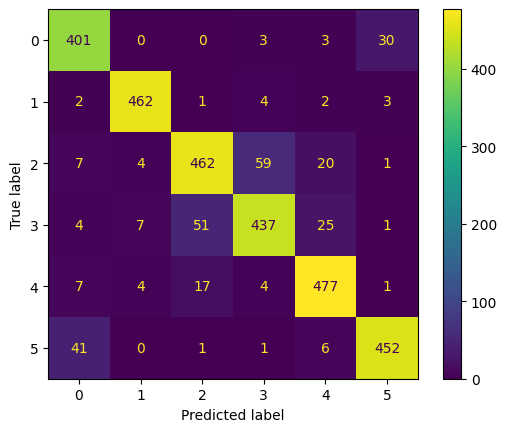

Test loss: 0.31716	 Test accuracy: 89.700% Test precision: 0.897 Test recall: 0.897Test f1: 0.897
Saving model


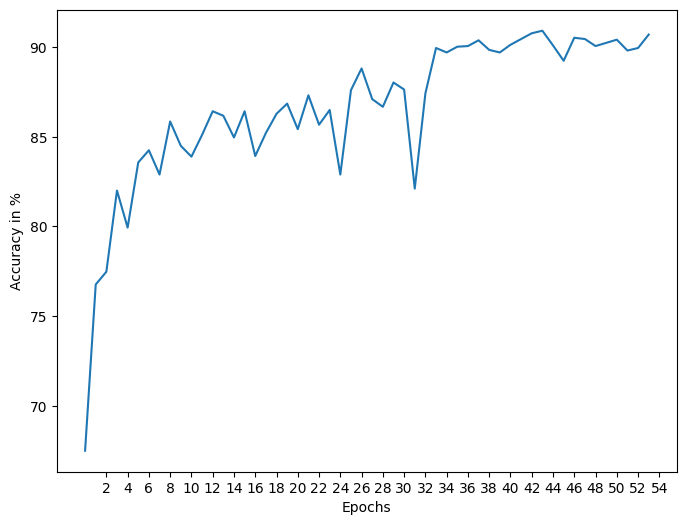

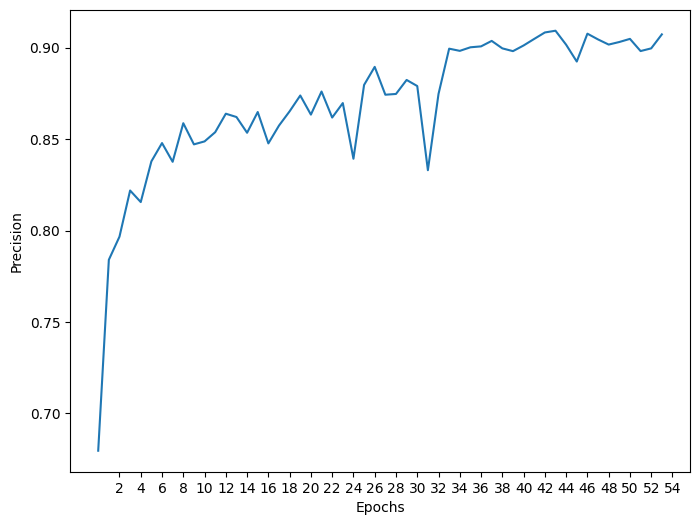

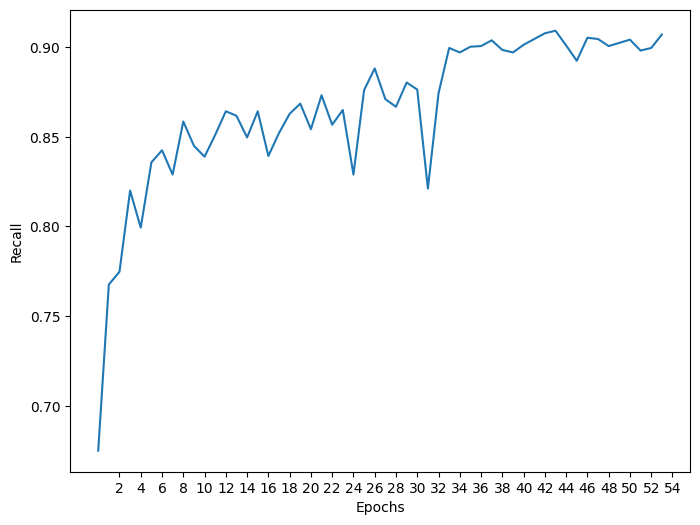

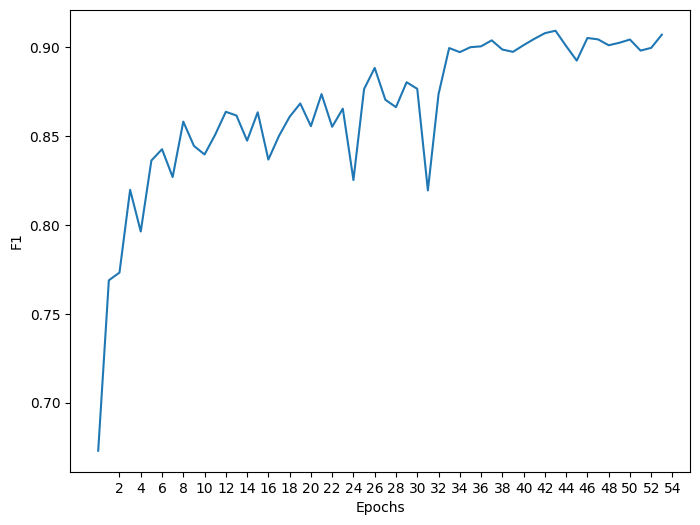

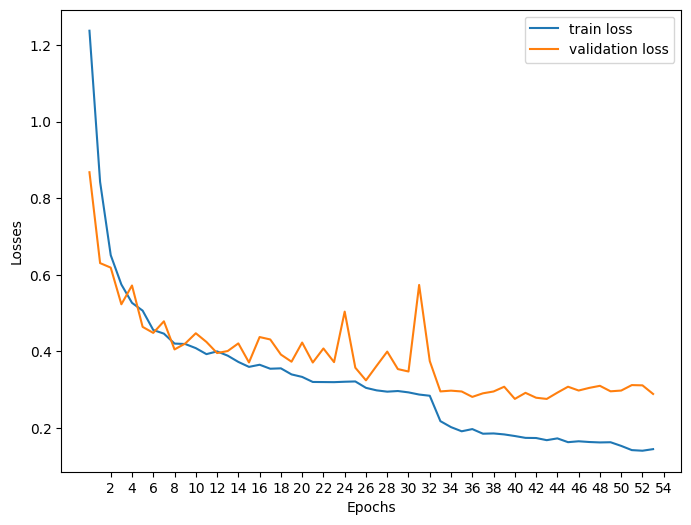

In [ ]:
with wandb.init(
        settings=wandb.Settings(start_method="thread"),
        project="Kaggle-Intel-Image",
        name='2d_conv_model',
        group='CNN',
        config={"epochs":n_epochs, "batch": BATCH_SIZE, "transforms": train_transforms},
        sync_tensorboard=False,
        resume="allow",
    ):

  train(model, criterion, optimizer, n_epochs, BATCH_SIZE, train_transforms, lr_scheduler=lr_sch, saving_model_path='2d_conv_model', wb=True)

In [ ]:
# Fitting nn model
#   0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
#   _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))

# epoch:   1, loss: 1.79933, valid loss: 1.79140, valid accuracy: 17.320, valid f1: 0.051%
# Validation loss decreased (inf --> 1.791401). Saving model...
#   2%|▏         | 1/50 [08:51<7:14:24, 531.93s/it]

#   Перша Конволюція із 150 призводить до таких результатів

In [ ]:
wandb.login()

True

In [ ]:
classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

Можливо ColorJitter руйнує? Бо маленькі feature map навпаки робили тільки гірше, можливо варто зменшити розмір зображення

### Висновки по тренуванню
- Достатньо афінних перетворень і перетворення в ч/б - на RandomCrop і Colorjitter
 більше 82% не підіймає, сфокусуватись і далі на усуненні схожості класів buildings і street, forest, mountain і glacier. Розуміє лише паттерни - прямі лінії в корі дерев, різкі обриси льодовиків тощо.

В датасеті присутні зображення з текстом класу

З Step_LR вийшло і decay 0.00001 дійшло 87%, не оверфітиться, проте і не може далі спускатися,
З ручно налаштованим lr 0.0007, 0.0003.
 нижче 1-e3 оверфітиться після 20 епох. ReduceOnPlateau дало найкращий результат на 89.5% після 18 епохи і спуску, проте вже тут досягаємо плато.


In [ ]:
# @title З меншим feature map модель, як вплине на продуктивність?

class FeatMapModel(nn.Module):
    def __init__(self):
        super().__init__()
        # 32 * 3 -> 16 -> 16
        self.bn11 = nn.BatchNorm2d(3)
        self.conv11 = nn.Conv2d(3, 16, 3, padding="same") #3/16
        self.bn12 = nn.BatchNorm2d(16) # 16
        self.conv12 = nn.Conv2d(16, 16, 3, padding="same") #16/16
        self.bn21 = nn.BatchNorm2d(16) # 16
        self.conv21 = nn.Conv2d(16, 32, 3, padding="same") #16/32
        self.bn22 = nn.BatchNorm2d(32) # 32
        self.conv22 = nn.Conv2d(32, 32, 3, padding="same") #32/32 -> 150 * 37 * 37
        # self.bn31 = nn.BatchNorm2d(75) # 16
        self.conv31 = nn.Conv2d(32, 64, 3, padding="same") #16/32 -> 450*9*9
        # self.bn32 = nn.BatchNorm2d(150) # 32
        self.conv32 = nn.Conv2d(64, 64, 3, padding="same") #32/32 -> 1350*2*2
        # self.fc1 = nn.Linear(256, 512) # 8192
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, len(classes))

    def forward(self, x):
        x = F.relu(self.conv11(self.bn11(x)))
        x=  F.relu(self.conv12(self.bn12(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = F.relu(self.conv21(self.bn21(x)))
        x = F.relu(self.conv22(self.bn22(x)))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        x = F.relu(self.conv31(x))
        x = F.relu(self.conv32(x))
        x = F.max_pool2d(x, 4)
        # print("\n", x.shape)
        # print(x.shape)
        x = x.view(-1, 256)
        # print(x.shape)
        # x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # x = F.dropout(F.relu(self.fc2(x)), 0.2)
        x = self.fc3(x)
        return x

- Зменшення feature map з 75 до 16 не лише зменшило продуктивність вдвічі, а і зробила будь-які паттерни створені CNN занадто малими, щоб бути корисними для моделі

- Validation accuracy нижчий за Test, що може свідчити про певну користь від аугментацій, коли модель не страждає від ускладнень зображення, пов'язаних з ними.



17% accuracy, 0.065% f1 після 5 епох - Не будемо далі тренувати

In [ ]:
n_epochs = 10

In [ ]:
device = torch.device('cuda')

In [ ]:
model = BasicModel().to(device)

## Завантажуємо претреновану модель на 86% accuracy

In [ ]:
check_point = torch.load(model_path('2d_conv_model'), map_location=device)
model.load_state_dict(check_point)

<All keys matched successfully>

In [ ]:
wandb.login()

True

In [ ]:
n_epochs=200

Compose(
      ToTensor()
      Compose(    RandomAffine(degrees=[-15.0, 15.0], translate=(0.05, 0.15), scale=(0.85, 1.15), interpolation=InterpolationMode.BILINEAR, fill=0))
      RandomGrayscale(p=0.2)
)

Fitting nn model


  0%|          | 0/200 [00:00<?, ?it/s]


epoch:   1, loss: 0.19387, valid loss: 0.16799, valid accuracy: 94.262, valid f1: 0.943%
Validation loss decreased (inf --> 0.167994). Saving model...


  1%|          | 2/200 [05:33<9:07:41, 165.97s/it]


epoch:   2, loss: 0.19237, valid loss: 0.17367, valid accuracy: 93.051, valid f1: 0.930%

epoch:   3, loss: 0.18791, valid loss: 0.16442, valid accuracy: 94.084, valid f1: 0.941%
Validation loss decreased (0.167994 --> 0.164417). Saving model...


  2%|▏         | 4/200 [10:20<8:13:15, 151.00s/it]


epoch:   4, loss: 0.19137, valid loss: 0.16559, valid accuracy: 94.084, valid f1: 0.941%


  2%|▎         | 5/200 [12:44<8:01:47, 148.24s/it]


epoch:   5, loss: 0.19039, valid loss: 0.16826, valid accuracy: 94.048, valid f1: 0.940%


  3%|▎         | 6/200 [15:07<7:53:48, 146.54s/it]


epoch:   6, loss: 0.18592, valid loss: 0.17115, valid accuracy: 93.550, valid f1: 0.935%


  4%|▎         | 7/200 [17:30<7:47:34, 145.36s/it]


epoch:   7, loss: 0.19453, valid loss: 0.17261, valid accuracy: 93.692, valid f1: 0.937%


  4%|▍         | 8/200 [19:53<7:42:51, 144.64s/it]


epoch:   8, loss: 0.18481, valid loss: 0.17024, valid accuracy: 93.799, valid f1: 0.938%


  4%|▍         | 9/200 [22:16<7:38:41, 144.09s/it]


epoch:   9, loss: 0.18908, valid loss: 0.16699, valid accuracy: 93.835, valid f1: 0.938%


  5%|▌         | 10/200 [24:39<7:35:27, 143.83s/it]


epoch:  10, loss: 0.18648, valid loss: 0.16493, valid accuracy: 93.906, valid f1: 0.939%


  6%|▌         | 11/200 [27:03<7:32:36, 143.69s/it]


epoch:  11, loss: 0.18545, valid loss: 0.17066, valid accuracy: 93.656, valid f1: 0.936%


  6%|▌         | 12/200 [29:25<7:29:25, 143.43s/it]


epoch:  12, loss: 0.19080, valid loss: 0.16875, valid accuracy: 93.906, valid f1: 0.939%


  6%|▌         | 12/200 [31:48<8:18:26, 159.08s/it]


epoch:  13, loss: 0.19295, valid loss: 0.17848, valid accuracy: 93.300, valid f1: 0.933%
Terminated Training for Early Stopping at Epoch 13
length array: 13
Fit time: 1908.9583158493042 s


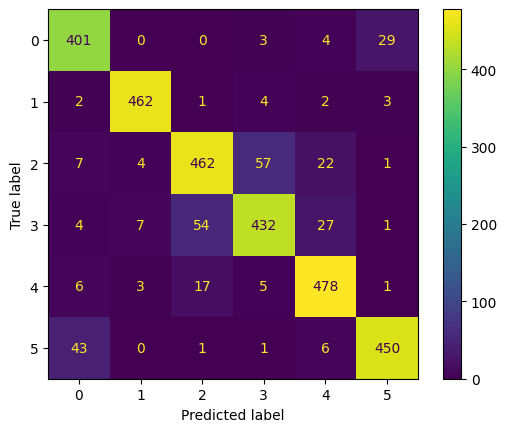

Test loss: 0.31989	 Test accuracy: 89.500% Test precision: 0.895 Test recall: 0.895Test f1: 0.895
Saving model


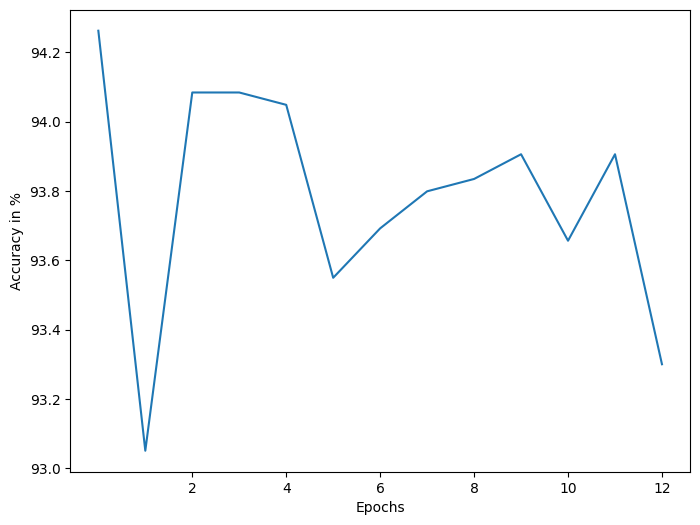

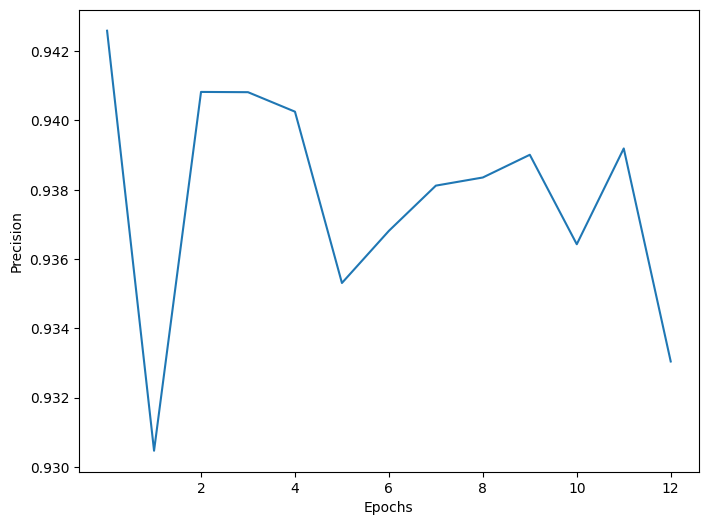

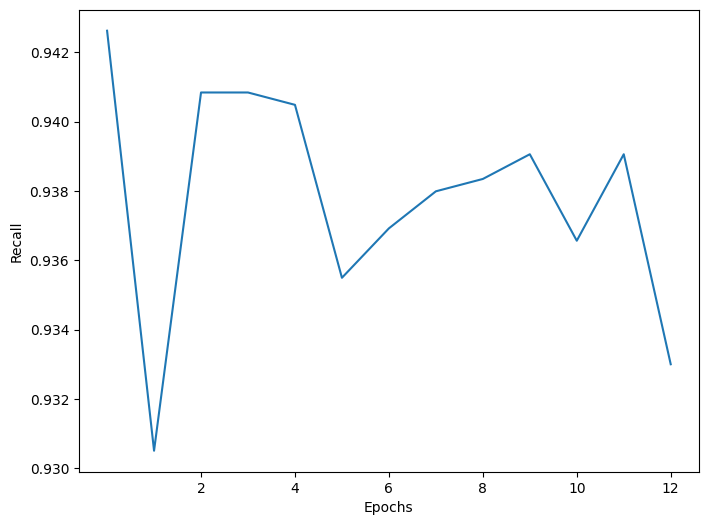

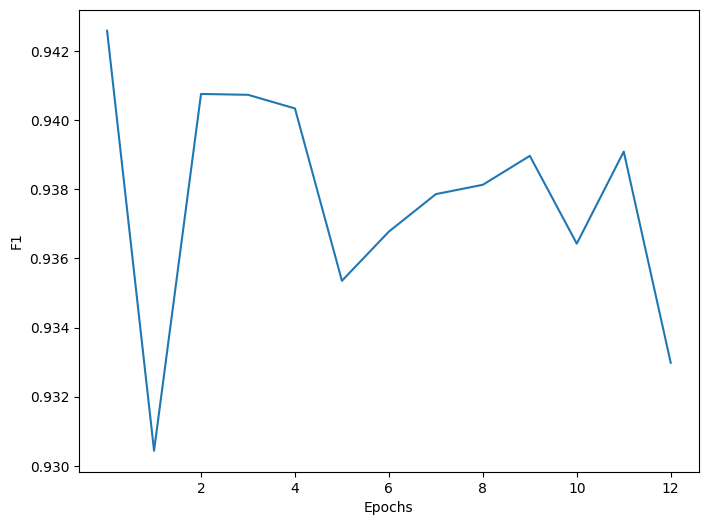

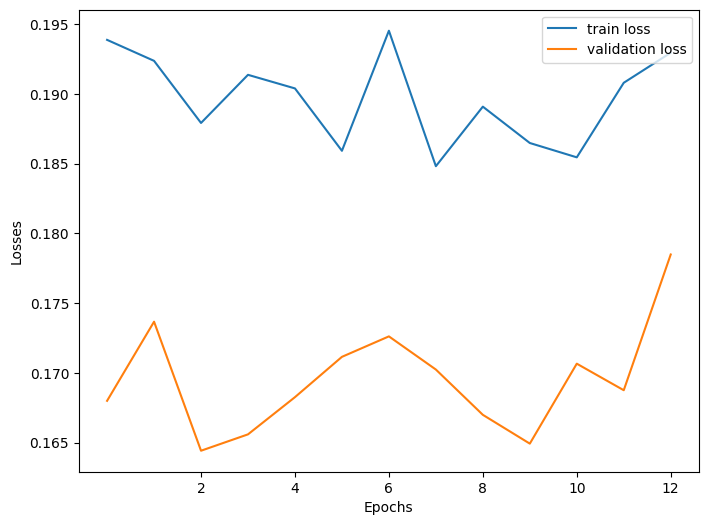

In [ ]:

with wandb.init(
          settings=wandb.Settings(start_method="thread"),
          project="Kaggle-Intel-Image",
          name='pretrained',
          group='CNN',
          config={"epochs":n_epochs, "batch": BATCH_SIZE, "transforms": train_transforms},
          sync_tensorboard=False,
          resume="allow",
      ):
  train(model, criterion, optimizer, n_epochs, BATCH_SIZE, train_transforms, lr_scheduler=lr_sch, saving_model_path='pretrained', wb=True)

In [ ]:
# Compose(
#       ToTensor()
#       Compose(    RandomAffine(degrees=[-15.0, 15.0], translate=(0.05, 0.15), scale=(0.85, 1.15), interpolation=InterpolationMode.BILINEAR, fill=0))
#       RandomGrayscale(p=0.2)
# )

# Fitting nn model
#   0%|          | 0/200 [00:00<?, ?it/s]
# epoch:   1, loss: 1.19252, valid loss: 0.82199, valid accuracy: 67.249, valid f1: 0.668%
# Validation loss decreased (inf --> 0.821986). Saving model...
#   0%|          | 1/200 [03:45<12:26:24, 225.05s/it]
# epoch:   2, loss: 0.79130, valid loss: 0.58484, valid accuracy: 78.190, valid f1: 0.781%
# Validation loss decreased (0.821986 --> 0.584842). Saving model...
#   2%|▏         | 3/200 [08:52<9:13:51, 168.69s/it]
# epoch:   3, loss: 0.62632, valid loss: 0.59879, valid accuracy: 77.940, valid f1: 0.777%

# epoch:   4, loss: 0.57283, valid loss: 0.52489, valid accuracy: 81.148, valid f1: 0.811%
# Validation loss decreased (0.584842 --> 0.524891). Saving model...
#   2%|▎         | 5/200 [13:36<8:14:49, 152.26s/it]
# epoch:   5, loss: 0.51663, valid loss: 0.68723, valid accuracy: 77.691, valid f1: 0.781%

# epoch:   6, loss: 0.49667, valid loss: 0.47125, valid accuracy: 81.860, valid f1: 0.818%
# Validation loss decreased (0.524891 --> 0.471253). Saving model...
#   3%|▎         | 6/200 [15:58<8:01:11, 148.82s/it]
# epoch:   7, loss: 0.48434, valid loss: 0.43030, valid accuracy: 84.141, valid f1: 0.841%
# Validation loss decreased (0.471253 --> 0.430298). Saving model...
#   4%|▎         | 7/200 [18:20<7:51:27, 146.57s/it]
# epoch:   8, loss: 0.46288, valid loss: 0.40964, valid accuracy: 85.353, valid f1: 0.854%
# Validation loss decreased (0.430298 --> 0.409636). Saving model...
#   4%|▍         | 9/200 [23:03<7:37:27, 143.70s/it]
# epoch:   9, loss: 0.42990, valid loss: 0.41989, valid accuracy: 84.533, valid f1: 0.846%
#   5%|▌         | 10/200 [25:24<7:32:39, 142.95s/it]
# epoch:  10, loss: 0.43177, valid loss: 0.46043, valid accuracy: 83.820, valid f1: 0.839%
#   6%|▌         | 11/200 [27:45<7:28:30, 142.39s/it]
# epoch:  11, loss: 0.41719, valid loss: 0.62273, valid accuracy: 79.116, valid f1: 0.793%

# epoch:  12, loss: 0.41132, valid loss: 0.35335, valid accuracy: 87.527, valid f1: 0.875%
# Validation loss decreased (0.409636 --> 0.353351). Saving model...
#   6%|▋         | 13/200 [32:28<7:22:12, 141.89s/it]
# epoch:  13, loss: 0.40203, valid loss: 0.49451, valid accuracy: 81.789, valid f1: 0.815%
#   7%|▋         | 14/200 [34:49<7:19:04, 141.64s/it]
# epoch:  14, loss: 0.38749, valid loss: 0.36755, valid accuracy: 86.921, valid f1: 0.869%
#   8%|▊         | 15/200 [37:10<7:15:58, 141.40s/it]
# epoch:  15, loss: 0.37559, valid loss: 0.36433, valid accuracy: 87.206, valid f1: 0.873%
#   8%|▊         | 16/200 [39:31<7:13:10, 141.25s/it]
# epoch:  16, loss: 0.36801, valid loss: 0.41288, valid accuracy: 85.780, valid f1: 0.859%
#   8%|▊         | 17/200 [41:52<7:10:46, 141.24s/it]
# epoch:  17, loss: 0.35835, valid loss: 0.43259, valid accuracy: 85.460, valid f1: 0.855%
#   9%|▉         | 18/200 [44:13<7:08:07, 141.14s/it]
# epoch:  18, loss: 0.36143, valid loss: 0.38605, valid accuracy: 86.386, valid f1: 0.863%

# epoch:  19, loss: 0.27928, valid loss: 0.30016, valid accuracy: 89.344, valid f1: 0.894%
# Validation loss decreased (0.353351 --> 0.300155). Saving model...
#  10%|▉         | 19/200 [46:34<7:05:15, 140.97s/it]
# epoch:  20, loss: 0.26372, valid loss: 0.28734, valid accuracy: 89.344, valid f1: 0.894%
# Validation loss decreased (0.300155 --> 0.287338). Saving model...
#  10%|█         | 21/200 [51:14<6:59:37, 140.66s/it]
# epoch:  21, loss: 0.25434, valid loss: 0.29142, valid accuracy: 89.629, valid f1: 0.896%
#  11%|█         | 22/200 [53:34<6:56:35, 140.42s/it]
# epoch:  22, loss: 0.25032, valid loss: 0.29198, valid accuracy: 89.522, valid f1: 0.895%

# epoch:  23, loss: 0.24859, valid loss: 0.28246, valid accuracy: 89.772, valid f1: 0.898%
# Validation loss decreased (0.287338 --> 0.282461). Saving model...
#  12%|█▏        | 24/200 [58:16<6:52:33, 140.64s/it]
# epoch:  24, loss: 0.24212, valid loss: 0.29400, valid accuracy: 89.594, valid f1: 0.896%
#  12%|█▎        | 25/200 [1:00:36<6:49:06, 140.27s/it]
# epoch:  25, loss: 0.23732, valid loss: 0.28776, valid accuracy: 90.164, valid f1: 0.902%
#  13%|█▎        | 26/200 [1:02:55<6:46:00, 140.00s/it]
# epoch:  26, loss: 0.23230, valid loss: 0.28586, valid accuracy: 89.772, valid f1: 0.898%
#  14%|█▎        | 27/200 [1:05:14<6:42:57, 139.76s/it]
# epoch:  27, loss: 0.22774, valid loss: 0.29029, valid accuracy: 90.235, valid f1: 0.903%
#  14%|█▍        | 28/200 [1:07:33<6:39:53, 139.50s/it]
# epoch:  28, loss: 0.23055, valid loss: 0.28667, valid accuracy: 89.594, valid f1: 0.896%
#  14%|█▍        | 29/200 [1:09:51<6:36:39, 139.18s/it]
# epoch:  29, loss: 0.22769, valid loss: 0.29327, valid accuracy: 89.701, valid f1: 0.897%
#  15%|█▌        | 30/200 [1:12:10<6:33:44, 138.97s/it]
# epoch:  30, loss: 0.21203, valid loss: 0.28591, valid accuracy: 90.485, valid f1: 0.905%

# epoch:  31, loss: 0.21136, valid loss: 0.27236, valid accuracy: 90.378, valid f1: 0.904%
# Validation loss decreased (0.282461 --> 0.272358). Saving model...
#  16%|█▌        | 31/200 [1:14:29<6:31:18, 138.93s/it]
# epoch:  32, loss: 0.20890, valid loss: 0.27080, valid accuracy: 90.378, valid f1: 0.904%
# Validation loss decreased (0.272358 --> 0.270804). Saving model...
#  16%|█▌        | 32/200 [1:16:47<6:28:38, 138.80s/it]
# epoch:  33, loss: 0.20942, valid loss: 0.26184, valid accuracy: 90.877, valid f1: 0.909%
# Validation loss decreased (0.270804 --> 0.261836). Saving model...
#  17%|█▋        | 34/200 [1:21:25<6:24:00, 138.80s/it]
# epoch:  34, loss: 0.20682, valid loss: 0.27171, valid accuracy: 90.556, valid f1: 0.906%
#  18%|█▊        | 35/200 [1:23:44<6:21:54, 138.87s/it]
# epoch:  35, loss: 0.20226, valid loss: 0.28465, valid accuracy: 90.413, valid f1: 0.904%
#  18%|█▊        | 36/200 [1:26:03<6:19:37, 138.89s/it]
# epoch:  36, loss: 0.20668, valid loss: 0.28084, valid accuracy: 90.413, valid f1: 0.904%
#  18%|█▊        | 37/200 [1:28:22<6:17:26, 138.93s/it]
# epoch:  37, loss: 0.20332, valid loss: 0.28292, valid accuracy: 89.986, valid f1: 0.900%
#  19%|█▉        | 38/200 [1:30:41<6:14:51, 138.84s/it]
# epoch:  38, loss: 0.20848, valid loss: 0.27708, valid accuracy: 90.520, valid f1: 0.906%
#  20%|█▉        | 39/200 [1:32:59<6:12:32, 138.84s/it]
# epoch:  39, loss: 0.20111, valid loss: 0.26939, valid accuracy: 90.306, valid f1: 0.903%
#  20%|██        | 40/200 [1:35:19<6:10:53, 139.08s/it]
# epoch:  40, loss: 0.20131, valid loss: 0.28375, valid accuracy: 89.843, valid f1: 0.899%
#  20%|██        | 41/200 [1:37:40<6:09:52, 139.57s/it]
# epoch:  41, loss: 0.20027, valid loss: 0.27738, valid accuracy: 90.556, valid f1: 0.906%
#  21%|██        | 42/200 [1:40:00<6:08:24, 139.90s/it]
# epoch:  42, loss: 0.19937, valid loss: 0.27761, valid accuracy: 90.164, valid f1: 0.902%

# epoch:  43, loss: 0.20063, valid loss: 0.26179, valid accuracy: 90.877, valid f1: 0.909%
# Validation loss decreased (0.261836 --> 0.261794). Saving model...
#  22%|██▏       | 44/200 [1:44:42<6:05:07, 140.43s/it]
# epoch:  44, loss: 0.20138, valid loss: 0.27083, valid accuracy: 90.734, valid f1: 0.908%
#  22%|██▎       | 45/200 [1:47:04<6:03:26, 140.69s/it]
# epoch:  45, loss: 0.20453, valid loss: 0.27234, valid accuracy: 90.342, valid f1: 0.904%
#  23%|██▎       | 46/200 [1:49:25<6:01:17, 140.77s/it]
# epoch:  46, loss: 0.20119, valid loss: 0.27172, valid accuracy: 90.342, valid f1: 0.903%
#  24%|██▎       | 47/200 [1:51:46<5:59:07, 140.83s/it]
# epoch:  47, loss: 0.20012, valid loss: 0.27278, valid accuracy: 90.128, valid f1: 0.901%
#  24%|██▍       | 48/200 [1:54:07<5:57:17, 141.03s/it]
# epoch:  48, loss: 0.20066, valid loss: 0.26682, valid accuracy: 90.663, valid f1: 0.907%
#  24%|██▍       | 49/200 [1:56:28<5:54:48, 140.98s/it]
# epoch:  49, loss: 0.19577, valid loss: 0.27019, valid accuracy: 90.556, valid f1: 0.906%
#  25%|██▌       | 50/200 [1:58:48<5:52:00, 140.80s/it]
# epoch:  50, loss: 0.20098, valid loss: 0.27773, valid accuracy: 90.128, valid f1: 0.901%
#  26%|██▌       | 51/200 [2:01:10<5:50:01, 140.95s/it]
# epoch:  51, loss: 0.20085, valid loss: 0.27474, valid accuracy: 90.805, valid f1: 0.908%
#  26%|██▌       | 52/200 [2:03:31<5:47:43, 140.97s/it]
# epoch:  52, loss: 0.20268, valid loss: 0.26870, valid accuracy: 90.413, valid f1: 0.904%
#  26%|██▌       | 52/200 [2:05:51<5:58:13, 145.23s/it]
# epoch:  53, loss: 0.20208, valid loss: 0.27227, valid accuracy: 90.235, valid f1: 0.903%
# Terminated Training for Early Stopping at Epoch 53
# length array: 53
# Fit time: 7551.886405944824 s

# Результати за посиланням на [wandb](https://wandb.ai/paradoxv15/Kaggle-Intel-Image/reports/Model-tuning-for-Intel-Image-classifier--VmlldzoxMTgxOTgwMA)



In [ ]:
entity = 'ENTER YOUR OWN'

In [ ]:
api = wandb.Api()
artifact = api.artifact(f"{entity}/Kaggle-Intel-Image/part_frozen_resnet3:v0")


In [ ]:
artifact.download(root='.')

In [ ]:
artifact.name

'part_frozen_resnet3:v0'

In [ ]:
check_point = torch.load(f'{artifact.name.split(":")[0]}.pt', map_location=device)

In [ ]:
pretrained = model.load_state_dict(check_point)

In [ ]:
data_train = Hdf5Dataset(train_hdf5, transform=train_transforms)

data_test = Hdf5Dataset(test_hdf5, transform=test_transforms)

data_train, data_valid = random_split(data_train, lengths=[0.8, 0.2])

loader_train = WrappedDataLoader(DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True), to_device)
loader_eval = WrappedDataLoader(DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=False), to_device)
loader_test = WrappedDataLoader(DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=False), to_device)

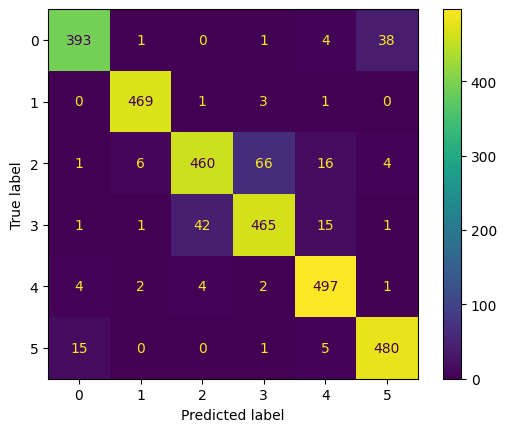

Test loss: 0.25589	 Test accuracy: 92.133% Test precision: 0.921 Test recall: 0.921Test f1: 0.921


In [ ]:
eval_losses = evaluate(model, criterion, loader_test)

In [ ]:
def validate_examples(model, loss_func, X, y):
    output = model(X)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)

    return X, pred, y.view(*pred.shape)

In [ ]:
def draw_predicted_examples(image_array, grid_x, grid_y, title):
    fig = plt.figure(figsize=(grid_x,grid_y))
    fig.suptitle(title, fontsize=20)

    for i in range(1,grid_y*grid_x+1):
        index = random.randint(0, len(image_array)-1)
        image = image_array[index]
        plt.axis('off')
        plt.subplot(grid_y,grid_x,i)
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))

In [ ]:
# Функція для денормалізації зображення
def denormalize_image(tensor, mean=0.5, std=0.5):
    # tensor має форму (channels, height, width); повертає зображення у форматі HxWxC
    img = tensor.cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean
    return np.clip(img, 0, 1)


# Функція для відображення зображень з прогнозами (оновлено)
def show_predictions(model, dataloader, class_names, device, num_images=8):
    """
    Відображає приклади зображень з прогнозами моделі.
    """
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            preds = preds.cpu()
            labels = labels.cpu()
            for j in range(inputs.size(0)):
                true_label = labels[j].item()
                pred_label = preds[j].item()
                if images_so_far >= num_images:
                    return
                images_so_far += 1
                ax = plt.subplot(2, num_images // 2, images_so_far)
                ax.axis("off")
                status = "✓" if preds[j] == labels[j] else "✗"
                ax.set_title(
                    f"{status} Predicted: {class_names[pred_label]}\nTarget: {class_names[true_label]}",
                    color="green" if true_label == pred_label else "red",
                    fontsize=10,
                )
                # Використовуємо утиліту для денормалізації
                img = denormalize_image(inputs[j])
                plt.imshow(img)
    plt.tight_layout()
    plt.show()


# Функція для відображення лише помилкових прогнозів (оновлено)
def show_misclassifications(model, dataloader, class_names, device, max_per_class=5):
    """
    Відображає приклади помилково класифікованих зображень для кожного класу.
    """
    model.eval()
    misclassified = {i: [] for i in range(len(class_names))}

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                true_label = labels[j].item()
                pred_label = preds[j].item()
                if (
                    true_label != pred_label
                    and len(misclassified[true_label]) < max_per_class
                ):
                    img = denormalize_image(inputs[j])
                    misclassified[true_label].append((img, pred_label))

    for class_idx, examples in misclassified.items():
        if not examples:
            continue
        plt.figure(figsize=(15, 3))
        plt.suptitle(
            f"Misclassified as '{class_names[class_idx]}'",
            fontsize=14,
        )
        for i, (img, pred_label) in enumerate(examples):
            plt.subplot(1, len(examples), i + 1)
            plt.imshow(img)
            plt.title(
                f"Target: {class_names[class_idx]}\Predicted: {class_names[pred_label]}",
                color="red",
            )
            plt.axis("off")
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


In [ ]:
data_train = Hdf5Dataset(train_hdf5, transform=train_transforms)

data_test = Hdf5Dataset(test_hdf5, transform=test_transforms)

data_train, data_valid = random_split(data_train, lengths=[0.8, 0.2])

loader_train = WrappedDataLoader(DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True), to_device)
loader_eval = WrappedDataLoader(DataLoader(data_valid, batch_size=BATCH_SIZE, shuffle=False), to_device)
loader_test = WrappedDataLoader(DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=False), to_device)

In [ ]:
device = torch.device('cuda')

In [ ]:
dataset = ImageDataset(URL, train=False)

In [ ]:
classes = dataset.classes


Приклади помилкових класифікацій CNN моделі:


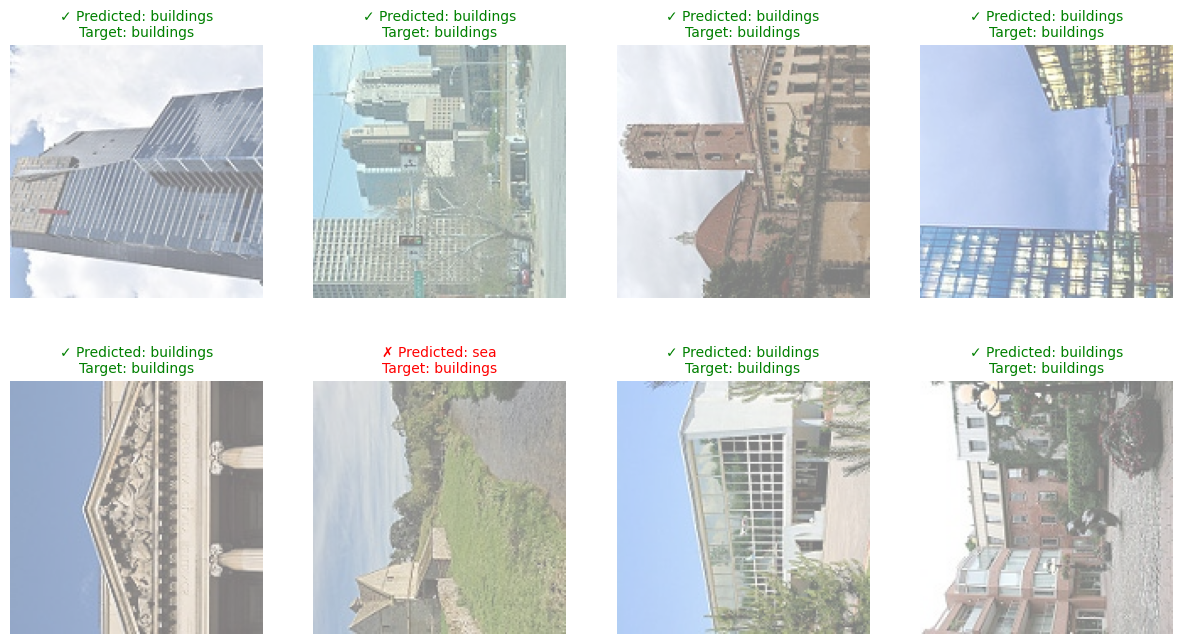

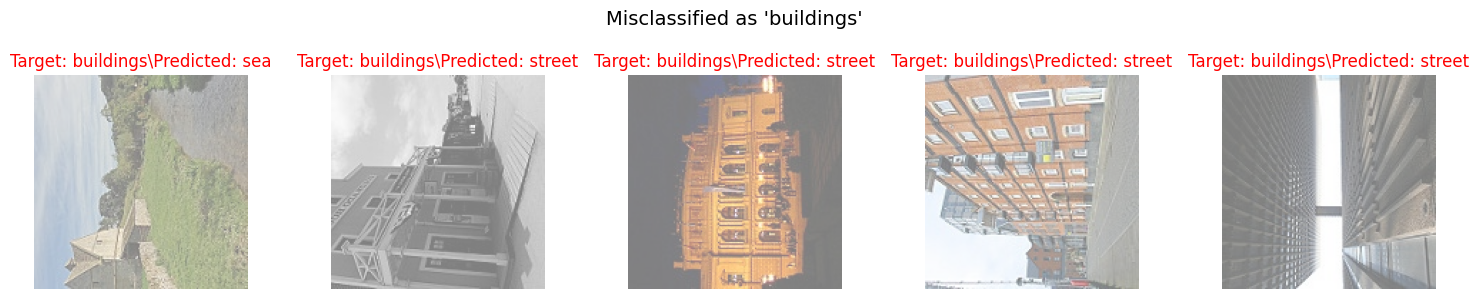

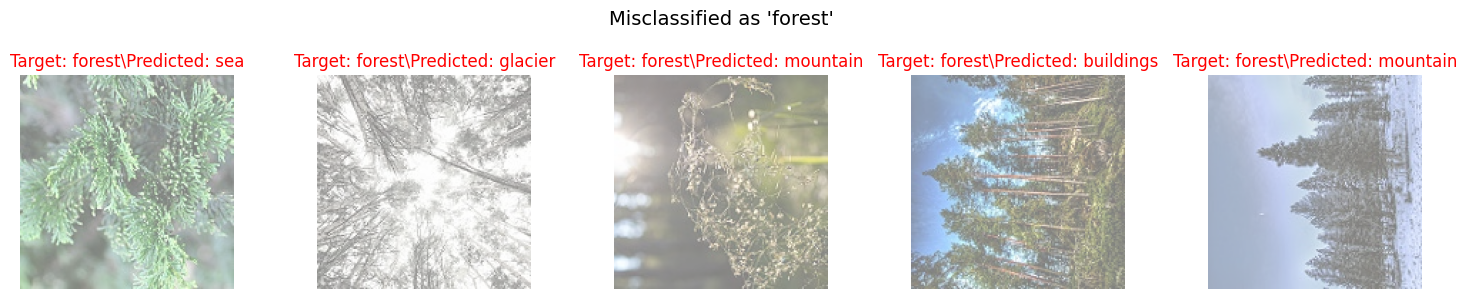

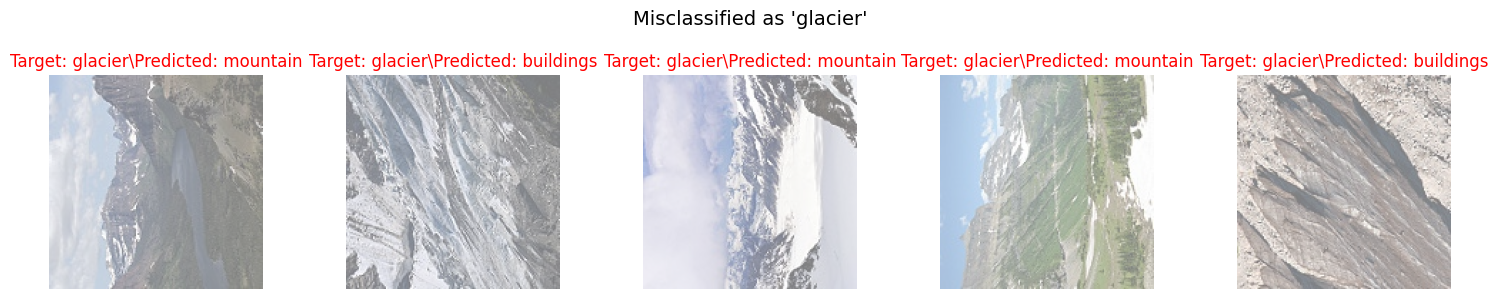

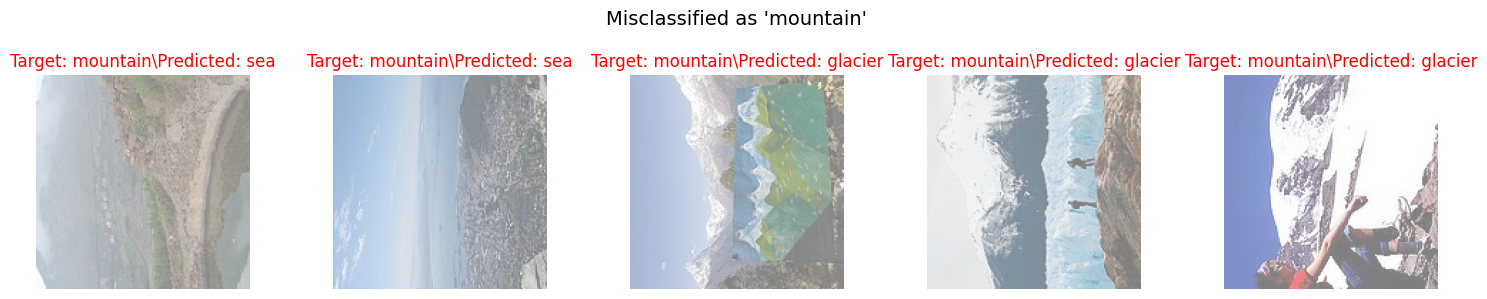

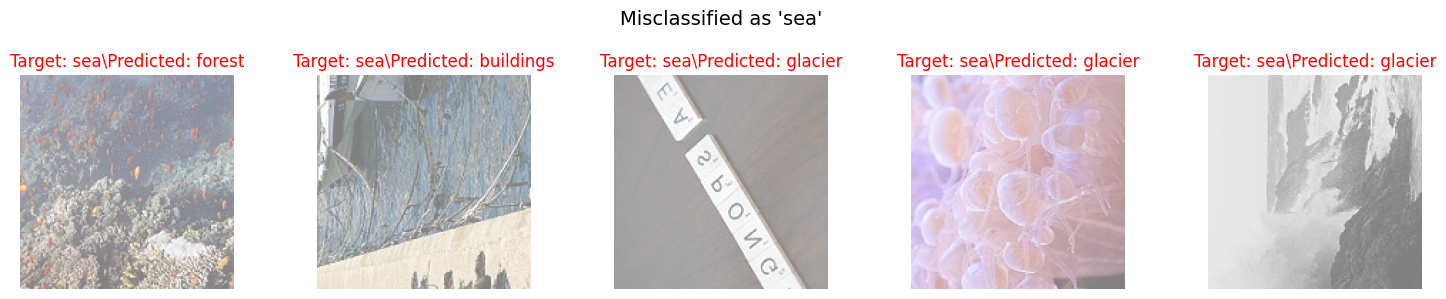

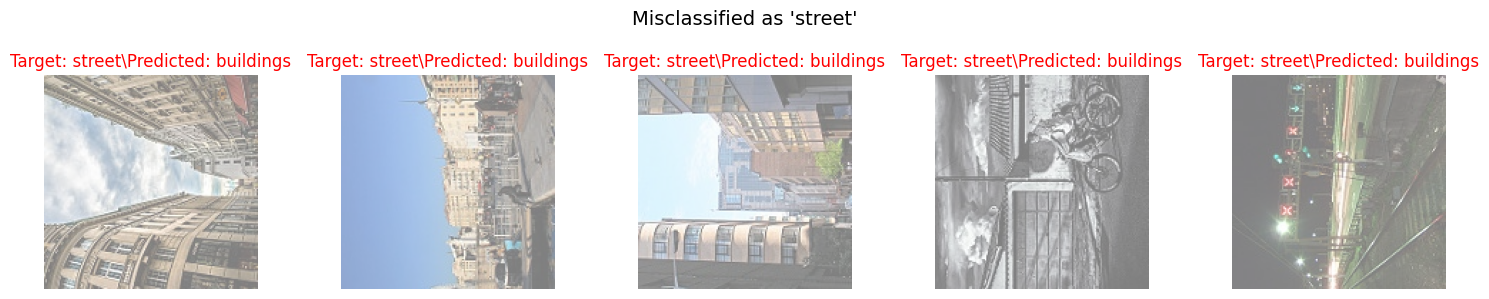

In [ ]:
# Показ прикладів прогнозів на валідаційному наборі
show_predictions(model, loader_test, classes, device)

# Показ прикладів ПОМИЛКОВИХ прогнозів для кожного класу
print("\nПриклади помилкових класифікацій CNN моделі:")
show_misclassifications(model, loader_test, classes, device)